In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from PIL import Image, ImageDraw
import os
import numpy as np
import sys

#copied from torchvision
from engine import train_one_epoch, evaluate
import utils
import transforms as T

import shutil
import heapq

In [2]:
import glob
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(glob.glob(os.path.join(root,"PNGImages")+'/*.png')))
        self.masks = list(sorted(glob.glob(os.path.join(root,"PedMasks")+'/*.png')))
 
    def __getitem__(self, idx):
        # load images ad masks
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
 
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
 
        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
 
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
 
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
 
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
 
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
 
        if self.transforms is not None:
            img, target = self.transforms(img, target)
 
        return img, target
 
    def __len__(self):
        return len(self.imgs)

In [3]:
def get_instance_segmentation_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    #Region Of Interest
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor =FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,hidden_layer,num_classes)

    return model

def get_transform(train):
    tf = []
    #T should be changed
    tf.append(T.ToTensor())
    if train:
        # transforms.append(T.Grayscale(3))
        # transforms.append(T.RandomErasing())
        tf.append(T.RandomHorizontalFlip(0.5))
    #randomaffine,randomgrayscale,randomerasing
    return T.Compose(tf)

In [4]:
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])
 
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)
 
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [6]:
for idx, data in enumerate(data_loader):
    img, target = data
    img = img[0]
    img = img.numpy()
    print(img.shape)
    break

(3, 353, 363)


(353, 363, 3)


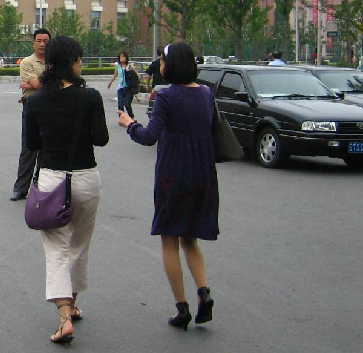

In [7]:
img, target = data
img = img[0]
img = img.mul(255).byte().cpu().numpy()
img = np.transpose(img,(1,2,0))
print(img.shape)
# chw

Image.fromarray(img)

In [8]:
# our dataset has two classes only - background and person
num_classes = 2
 
# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)
 
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
 
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [9]:
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

B:\anaconda3\envs\web_env_3.7\lib\site-packages\torch\nn\functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [  0/120]  eta: 0:03:30  lr: 0.000047  loss: 1.8590 (1.8590)  loss_classifier: 0.4505 (0.4505)  loss_box_reg: 0.1063 (0.1063)  loss_mask: 1.2643 (1.2643)  loss_objectness: 0.0358 (0.0358)  loss_rpn_box_reg: 0.0021 (0.0021)  time: 1.7550  data: 0.0110  max mem: 972
Epoch: [0]  [ 10/120]  eta: 0:00:48  lr: 0.000467  loss: 1.4346 (1.5377)  loss_classifier: 0.4011 (0.3995)  loss_box_reg: 0.3102 (0.3011)  loss_mask: 0.7573 (0.8034)  loss_objectness: 0.0222 (0.0298)  loss_rpn_box_reg: 0.0030 (0.0039)  time: 0.4442  data: 0.0225  max mem: 1671
Epoch: [0]  [ 20/120]  eta: 0:00:38  lr: 0.000886  loss: 0.7934 (1.1460)  loss_classifier: 0.2158 (0.2885)  loss_box_reg: 0.2652 (0.2762)  loss_mask: 0.3588 (0.5552)  loss_objectness: 0.0086 (0.0209)  loss_rpn_box_reg: 0.0031 (0.0052)  time: 0.3123  data: 0.0232  max mem: 1703
Epoch: [0]  [ 30/120]  eta: 0:00:32  lr: 0.001306  loss: 0.6141 (0.9631)  loss_classifier: 0.1272 (0.2361)  loss_box_reg: 0.2560 (0.2684)  loss_mask: 0.2096 (0.4332)  

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [ ]:
device